# Исследование надёжности заёмщиков #

Заказчик — кредитный отдел банка. Цель проекта заключается в проверке гипотезы о том, что те или иные характеристики заёмщика влияют на факт погашения кредита в срок. Задачи, решение которых потребуется для достижения цели: 
* ознакомиться с полученными данными и провести их предобработку;
* выполнить исследование данных для проверки гипотезы и выявления взаимосвязей наличия задолженности по кредиту:
    * с наличием детей и их количеством;
    * с семейным положением заёмщиков;
    * с уровнем дохода;
    * целями, для которых предоставлен кредит.

Входные данные от банка — статистика о платёжеспособности клиентов.

План работы над проектом:
- ознакомиться с данными, представленными для исследования;
- выполнить предобработку данных:
    - определить имеются ли пропуски в данных и заполнить их;
    - определить корректность типов данных для анализа, при необходимости заменить типы данных;
    - выявить и удалить дубликаты;
    - провести лемматизацию данных о целях предоставления кредитов для последюущего анализа;
    - выполнить категоризацию данных.
- выявить взаимосвязи между семеными положением, количеством детей у заёмщиков и наличием задолженности по кредитам. 

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

Для начала ознакомимся с общей информацией о датасете: количеством столбцов и строк, наименованием столбцов и типами данных в них, с конкретными данными датасета.   

Импортируем необходимые библиоткеи и модули: 

In [2]:
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)
import numpy as np
from collections import Counter
from pymystem3 import Mystem
m = Mystem()
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 8)})

Сохраним анализируемый датафрейм в переменной *df*:

In [3]:
try:
    df = pd.read_csv(r'C:\Users\USER\Desktop\DA\data.csv')
except:
    df = pd.read_csv('/datasets/data.csv')

Ознакомимся с общей информацией о таблице и данными в ней с помощью метода `info()`:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Всего в таблице 21 525 строк и 12 столбцов. Наименование столбцов и описание содержащихся в них данных:  
- *children* — количество детей в семье  
- *days_employed* — общий трудовой стаж в днях  
- *dob_years* — возраст клиента в годах  
- *education* — уровень образования клиента  
- *education_id* — идентификатор уровня образования  
- *family_status* — семейное положение  
- *family_status_id* — идентификатор семейного положения  
- *gender* — пол клиента  
- *income_type* — тип занятости  
- *debt* — имел ли задолженность по возврату кредитов  
- *total_income* — ежемесячный доход  
- *purpose* — цель получения кредита  

Данные таблицы достаточны для проведения исследования. В том числе, датафрейм содержит сведения о семейном статусе заёмщиков, о количестве детей, ежемесячном доходе и целей предоставления кредитов, которые необходимы для достижения цели исследования.

Столбцы датасета имеют корректные наименования за исключением столбца *dob_years*, из наименования которого очевидно не следует, что в нём содержатся данные о возрасте клиента.   
Поэтому переименуем столбец *dob_years* в *age* и проверим удалось ли переименовать столбец путём вызова метода `columns`:

In [5]:
df.rename(columns={'dob_years':'age'}, inplace=True)
df.columns

Index(['children', 'days_employed', 'age', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

Столбец *dob_years* был успешно переимнован в *age*.

Выведем первые 5 строк таблицы с помощью метода `head()`, чтобы ознакомиться какие данные содержатся в ней:

In [6]:
df.head()

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,"-8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья
1,1,"-4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля
2,0,"-5,623.42",33,Среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья
3,3,"-4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу


Как видим, часть данных имеет отрицательные значения хотя описывает количество дней, одни и те же значения написаны разным регистром или с помощью синонимичных словосочетаний. Следовательно, данные необходимо подготовить для анализа.

**Вывод**

Данные, содержащиеся в датафрейме, являются достаточными для проведения исследования и проверки гипотезы. Однако ознакомление с конкретными данными позволило выявить недостатки в данных, устранение которых будет проведено на этапе предобработки данных.

## Шаг 2. Предобработка данных

### Обработка пропусков

Проверим есть ли строки, которые полностью состоят из отсутствующих значений. При налчии таких строк удалим их:

In [7]:
df.dropna(how='all') # применим зададим методу dropna параметр how cо значением 'all', 
                            # чтобы проверить наличие строк в датафрейме, полностью состоящих из NaN

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,"-8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья
1,1,"-4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля
2,0,"-5,623.42",33,Среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья
3,3,"-4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,"-4,529.32",43,среднее,1,гражданский брак,1,F,компаньон,0,"224,791.86",операции с жильем
21521,0,"343,937.40",67,среднее,1,женат / замужем,0,F,пенсионер,0,"155,999.81",сделка с автомобилем
21522,1,"-2,113.35",38,среднее,1,гражданский брак,1,M,сотрудник,1,"89,672.56",недвижимость
21523,3,"-3,112.48",38,среднее,1,женат / замужем,0,M,сотрудник,1,"244,093.05",на покупку своего автомобиля


После применения метода `dropna()` с параметром `how='all'` количество строк в датасете осталось неизменным - 21 525. Следовательно, строки, состоящие только из пропущенных значеницй, в таблице отсутствуют.

Посчитаем количество пропусков в каждом столбце датасета путём применения методов `isnull()` и `sum()`:

In [8]:
df.isna().sum()

children               0
days_employed       2174
age                    0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Пропуски обнаружены только в столбцах *days_employed* и *total_income*. Рассчитаем процент пропущенных значений в соответствующих столбцах с помощью цикла:

In [9]:
# Создадим цикл for с переменной col, а в качестве данных, по которым будет проходить цикла укажем столбцы,
# в которых обнаружены пропущенные значения. Сохраним в переменной missing примнение функции np.mean, которая 
# посчитает количество пропущенных значений в столбце и разделит его на общее количество значений в столбце. 
# Результат выведем на экран в виде "столбец - процент пропущенных данных в нём",применив функцию format.

for col in df[['days_employed', 'total_income']]:
    missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(missing*100)))

days_employed - 10%
total_income - 10%


Количество дней трудового стажа и ежемесячного дохода пропущены в 10% записей, что является существенным и может повлиять на результаты исследования.   

При этом количество пропусков в указанных столбцах одинаковое (2 174), поэтому можно предположить, что пропуски допущены в одних и тех же строках. Проверим это предположение с помощью логической индексации и оператора `&` - если в результате количество пропущенных значений не изменится, значит пропуски в столбцах *days_employed* и *total_income* допущены в одних и тех же столбцах. Резльтат сохраним в перемнной *missed_values_total*:

In [10]:
missed_values_total = df[df['total_income'].isnull() & df['days_employed'].isnull()]
missed_values_total.shape # чтобы узнать количество строк используем метод shape

(2174, 12)

Количество строк с пропущенными значениями не изменилось (2 174), что подтверждает наше предположение о пропусках в столбцах *days_employed* и *total_income* в одних и тех же строках.  

Определим есть ли взаимосвязь между пропущенными данными в столбцах *total_income* и *days_employed* с иными данными датасета. Для этого узнаем у заёмщиков какого типа занятости, обрзования и возраста чаще всего пропущены значения: 

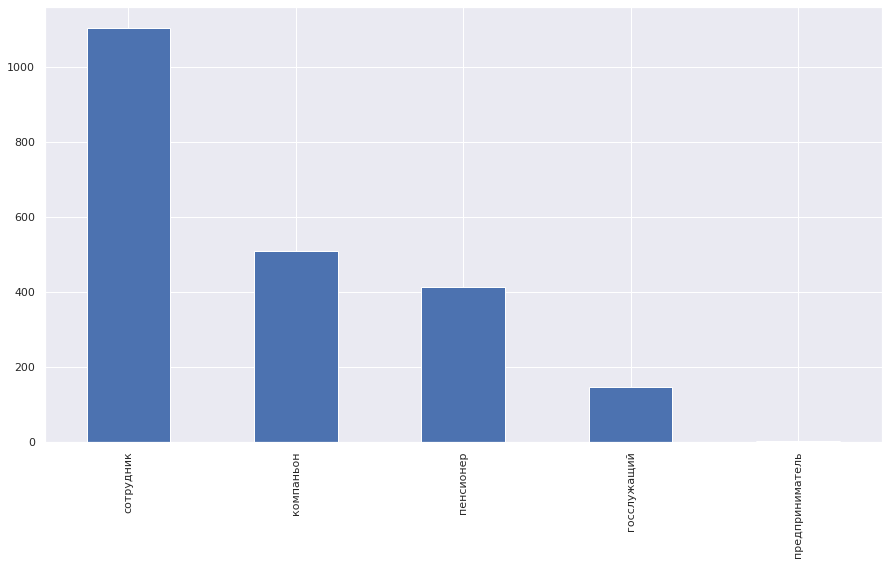

In [11]:
# Посчитаем количество уникальных значений в столбце income_type с помощью метода value_counts().
# Результат выведем на экран в виде диаграммы.
missed_values_income_type = missed_values_total['income_type'].value_counts().plot.bar()

Чаще всего данные прпущены у заёмщиков с типом занятости "сотрудник". 

Теперь узнаем у заёмщиков с каким уровнем образования вероятность встретить пропущенные значения выше:

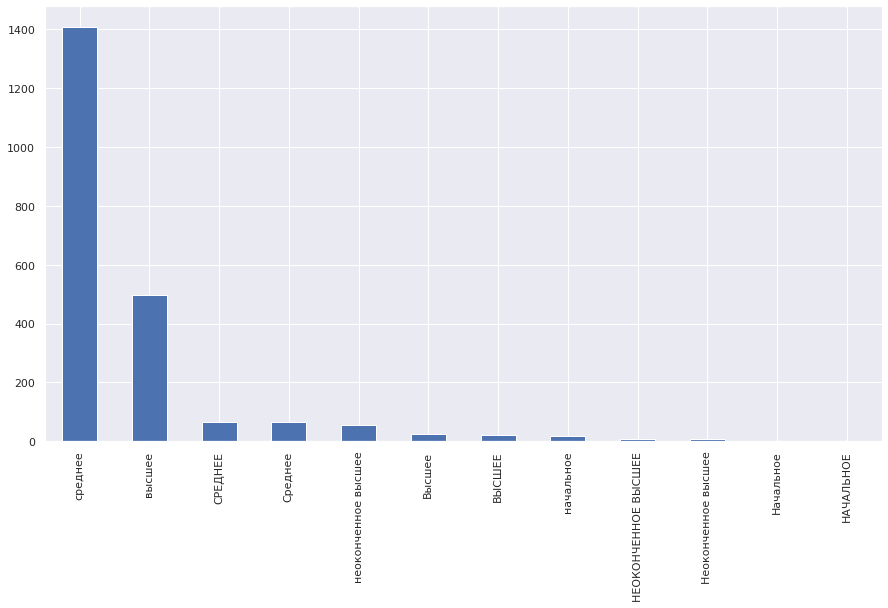

In [12]:
# Код аналогичен ранее выполненному, только считается уникальное количество значений в столбце education
missed_values_education = missed_values_total['education'].value_counts().plot.bar()

Определим в какой возрастной группе заёмщиков чаще всего встречаются пропуски. Для этого напишем цикл с счётчиком, который посчитает сколько раз пропущенные данные встречаются в той или иной возрастной группе заёмщиков:

In [13]:
age_under_30 = 0 # В данной перемнной будем сохранять количество пропусков по заёмщикам до 29 лет.
age_30s = 0 # <...> от 30 до 39 лет включительно.
age_40s = 0 # <...> от 40 до 49 лет включительно.
age_50s = 0 # <...> от 50 до 59 лет включительно.
age_60s = 0 # <...> от 60 до 69 лет включительно.
age_over_70 = 0 # <...> старше 70 лет.

for i in missed_values_total['age']: # Проверим каждое значение в столбце age в переменной missed_value_total.
    if i <= 29: # Если возраст заёмщика 29 лет и менее,
        age_under_30 += 1 # то будем добавлять единицу в соответствующую переменную-счётчик.
    elif i >= 30 and i <= 39: # Напишим аналогичные условия и для иных возрастных категорий.
        age_30s += 1
    elif i >= 40 and i <= 49:
        age_40s += 1
    elif i >= 50 and i <= 59:
        age_50s += 1
    elif i >= 60 and i <= 69:
        age_60s += 1
    elif i >= 70:
        age_over_70 += 1

# Выведем на экран количество пропущенных значений по каждой возрастной категории заёмщиков.
print('Количество пропущенных значений по заёмщикам до 30 лет:', age_under_30)
print('Количество пропущенных значений по заёмщикам 30 - 39 лет:', age_30s)
print('Количество пропущенных значений по заёмщикам 40 - 49 лет:', age_40s)
print('Количество пропущенных значений по заёмщикам 50 - 59 лет:', age_50s)
print('Количество пропущенных значений по заёмщикам 60 - 69 лет:', age_60s)
print('Количество пропущенных значений по заёмщикам старше 70 лет:', age_over_70)

print('Медианный возраст заёмщиков, по которым пропущены значения:', missed_values_total['age'].median())

Количество пропущенных значений по заёмщикам до 30 лет: 309
Количество пропущенных значений по заёмщикам 30 - 39 лет: 565
Количество пропущенных значений по заёмщикам 40 - 49 лет: 537
Количество пропущенных значений по заёмщикам 50 - 59 лет: 501
Количество пропущенных значений по заёмщикам 60 - 69 лет: 251
Количество пропущенных значений по заёмщикам старше 70 лет: 11
Медианный возраст заёмщиков, по которым пропущены значения: 43.0


Соответственно, вероятность встретить пропущенные данные выше среди заёмщиков возрастных групп 30 - 39 лет, 40 - 49 лет и 50 - 59 лет.

Таким обарзом, вероятность пропуска данных о трудовом стаже и ежемесячном доходе выше среди заёмщиков-сотрудников со средним образованием в возрасте 30 - 49 лет. 

Соберём данные о заёмщиках-сотрудниках со средним образованием в возрасте 30 - 59 лет в переменную *missed_for_mean* и узнаем количество соответствующих значений:

In [14]:
# Сделаем соответствующую выборку с помощью логической индексации. Будем сохранять в переменную 
# missed_for_median все строки missed_values_total, которые соответствуют условиям: образование - среднее
# (с учётом разного регистра), тип занятости - сотрудник, возраст - от 30 до 59 лет.
# В итоге определим количество заёмщиков, соответствующих этим критериям, по которым пропущены данные.

missed_for_median = missed_values_total[
    ((missed_values_total['education'] == 'среднее') & 
    (missed_values_total['income_type'] == 'сотрудник') &
    ((missed_values_total['age'] >= 30) & (missed_values_total['age'] <= 59))) |
    ((missed_values_total['education'] == 'СРЕДНЕЕ') &
    (missed_values_total['income_type'] == 'сотрудник') &
    ((missed_values_total['age'] >= 30) & (missed_values_total['age'] <= 59))) |
    ((missed_values_total['education'] == 'Среднее') & 
    (missed_values_total['income_type'] == 'сотрудник') &
    ((missed_values_total['age'] >= 30) & (missed_values_total['age'] <= 59)))]
missed_for_median.shape

(651, 12)

Как видно, в 651 случаях из 2 174 данные о трудовом стаже и ежемесячном доходе пропущены у заёмщиков, которые являются наёмными работниками, имеют среднее образование и возраст 30 - 59 лет. Поэтому можно предположить, что пропуски связаны с некоторой закономерностью (MAR). В случае MAR обработка пропусков считается допустимой. Что не исключает возможности пропуска данных из-за технических ошибок.

Учитывая, что у нас есть данные о трудовом стаже и доходе аналогичных заёмщиков, для заполнения пропусков возможно воспользоваться медианными значениями. Поскольку данные пропущены чаще всего у работающих заёмщиков со средним образованием в возрасте 30 - 59 лет, определим медианное значение трудового стажа для данной категории заёмщиков и сохраним в переменной *days_employed_mean*, а результат выведем на экран:

In [15]:
# Выполним фильтрацию данных с помощью функции days_employd_for_median, которая будет принимать аргументы:
# education_1, education_2, education_3 - среднее образование, с учётом различий в регистре;
# income_type - сотрудник;
# age_min - минимальная возрастная граница заёмщиков, 30 лет;
# age_max - максимальная возрастная граница заёмщиков, 59 лет.
# В функции объявим переменную days_employed_median, в которой сохраним данные по займщикам с помощью
# логической индексации. Возвращать функция будет медианное значение трудового стажа для заёмщиков,
# соответствующих объявленным требованиям образования, типа занятости и возраста в параметрах функции.

def days_employed_for_median(education_1, education_2, education_3, income_type, age_min, age_max):
    days_employed_median = df[
        (df['days_employed'].notnull()) & 
        ((df['education'] == education_1) | 
         (df['education'] == education_2) | 
         (df['education'] == education_3)) &
        ((df['income_type'] == income_type)) &
        ((df['age'] >= age_min) & (df['age'] <= age_max))
        ]
    return days_employed_median["days_employed"].median()

# Выведем медианное значение трудового стажа для указанной выборки заёмщиков на экран.
print(f'Медианное значение трудового стажа составляет {days_employed_for_median("среднее", "СРЕДНЕЕ", "Среднее", "сотрудник", 30, 59)}')

Медианное значение трудового стажа составляет -1799.5275163883286


Теперь заменим пропуски в столбце *days_employed* основного датасета медианным значением:

In [16]:
# Посчитаем количество пропусков до их заполнения с помощью функицй isna() и sum().
print('Пропуски в столбце days_employed до:', df['days_employed'].isna().sum())

# Заменим пропуски, для чего сначала с помощью функции .loc обратимся к ячейкам с пропущенными значениями
# в столбце days_employed, применив функцию isna(). Правее оператора присвоения обратимся к ранее 
# написанной функции days_employed_for_median с необходимыми параметрами заёмщиков.
df.loc[df['days_employed'].isna(), ['days_employed']] = days_employed_for_median("среднее", "СРЕДНЕЕ", "Среднее", "сотрудник", 30, 59)

# Посчитаем количество пропусков в столбце после их заполнения.
print('Пропуски в столбце days_employed после:', df['days_employed'].isna().sum())

Пропуски в столбце days_employed до: 2174
Пропуски в столбце days_employed после: 0


Пропуски в столбце *days_employd* заполнены медианным значением. 
Теперь аналогичным образом определим медианное значение ежемесячного дохода у заёмщиков-сотрудников со средним образованием в возрасте 30 - 59 лет, отфильтровав данные с помощью функции, выведем результат медианного значения на экран:

In [17]:
# Выполним фильтрацию данных с помощью функции total_income_for_median, которая будет принимать аргументы,
# аналогичные предыдущей функции. Но возвращать функция будет медианное значение ежемесячного дохода
# заёмщиков, соответствующих объявленным параметрам.

def total_income_for_median(education_1, education_2, education_3, income_type, age_min, age_max):
    total_income_median = df[
        (df['days_employed'].notnull()) & 
        ((df['education'] == education_1) | 
         (df['education'] == education_2) | 
         (df['education'] == education_3)) &
        ((df['income_type'] == income_type)) &
        ((df['age'] >= age_min) & (df['age'] <= age_max))
        ]
    return total_income_median['total_income'].median()
print(f'Медианное значение ежемесячного дохода составляет {total_income_for_median("среднее", "СРЕДНЕЕ", "Среднее", "сотрудник", 30, 59)}')

Медианное значение ежемесячного дохода составляет 138117.20904677408


Заполним пропуски в столбце *total_income*:

In [18]:
# Посчитаем количество пропусков до их заполнения с помощью функицй isna() и sum().
print('Пропуски в столбце total_income до:', df['total_income'].isna().sum())

# Заменим пропуски, для чего сначала с помощью функции .loc обратимся к ячейкам с пропущенными значениями
# в столбце total_income, применив функцию isna(). Правее оператора присвоения обратимся к функции 
# total_income_for_median с необходимыми параметрами заёмщиков.
df.loc[df['total_income'].isna(), ['total_income']] = total_income_for_median("среднее", "СРЕДНЕЕ", "Среднее", "сотрудник", 30, 59)

# Посчитаем количество пропусков в столбце после их заполнения.
print('Пропуски в столбце total_income после:', df['total_income'].isna().sum())

Пропуски в столбце total_income до: 2174
Пропуски в столбце total_income после: 0


Таким образом, все пропущенные значения трудового стажа и ежемесячного дохода в датасете были заполнены медианными значениями для категории заёмщиков, анологичных тем по которым чаще всего встречаются пропуски.

**Вывод**

Пропущенные значения в исходном датасете были обнаружены в столбцах *days_employed* и *total_income*. В каждом столбце отсутствовало порядка 10% данных, что могло бы повлиять на результат исследования.  
Нами было установлено, что пропуски содержатся в одних и тех столбцах. При этом вероятность пропуска соответствующих значений была гораздо выше в отношении заёмщиков с *income_type - "сотрудник"*, *education - "среднее"* и *age - от 30 до 59*. Поэтому отсутствующие значения о трудовом стаже и ежемесячном доходе были заменены медианами для данной категории заёмщиков.   
В итоге пропущенные данные были заполнены.

### Замена типа данных

В столбце *days_employed*, который содержит данные об общем трудовом стаже в днях, содержатся данные типа *float*. Для демонстрации выведем первые 5 строк датасета: 

In [19]:
df.head()

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,"-8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья
1,1,"-4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля
2,0,"-5,623.42",33,Среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья
3,3,"-4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу


Вещественный тип данных невозможен для данных о трудовом стаже (трудовой стаж не может измеряться как "100 дней и 12 часов 15 минут"). Поэтому необходимо заменить тип данных в указанном столбце.  

Кроме того, встречаются отрицательные данные об общем трудовом стаже, чего также не может быть. Изменим отрицательные данные на положительные с помощью метода `abs` и проверим результат выводом первых 5 строк на экран:

In [20]:
df['days_employed'] = df['days_employed'].apply(abs) # Функция abs возвращает модуль числа, поэтому 
                                                     # может быть использована для замены отрицательных
                                                     # чисел на положительные.
df.head(5)

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,"8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья
1,1,"4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля
2,0,"5,623.42",33,Среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья
3,3,"4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу


Изменим тип данных столбца *days_employed* на целочисленный и проверим результат:

In [21]:
# Чтобы изменить тип данных на целочисленный обратимся к функции astype с параметром int
df['days_employed'] = df['days_employed'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
age                 21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
dtypes: float64(1), int64(6), object(5)
memory usage: 2.0+ MB


В результате данные о трудовом стаже были приведены к целочисленному типу. Однако они продолжают аномально выглядеть - некоторые значения измеряются в сотнях тысяч дней, что представляется маловероятным. Следовательно, некоторая часть данных в рассматриваемом столбце указана всё-таки не в днях, а в иных значениях. Поскольку данные указанного столбца не требуются для проверки основной гипотезы, оставим выяснение данного вопроса за рамками исследования.

**Вывод**

В рамках предобработки данных было выявлено, что данные в столбце *days_employed* имеют вещественный тип (float), а также встречаются отрицательные значения, которые не могут характеризовать значения дней трудового стажа. Поэтому отрицательные числа были переведены в положительные, а тип данных в столбце заменён на целочисленный (int).

### Обработка дубликатов

Посчитаем количество уникальных значений столбцах с типом данных *object* - *education* и *purpose*:

In [22]:
print(df['education'].value_counts())
print(df['purpose'].value_counts())

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64
свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
жилье                                     647
покупка жилья                             647
покупка жилья для семьи                   641
строительство собственной нед

В столбцах *education* и *purpose* встречаются одинаковые значения. Так, в столбце *education* значение указывается в разных регистрах, поэтому для 5 значений ("начальное", "среднее", "неоконченное высшее", "высшее", "ученая степень") используется 15 способов написания. В столбце *purpose* одинаковые по смыслу сведения внесены разными синонимичными формулировками.


Обработаем дубликаты в столбце *education* для чего приведём все значения к нижнему регистру, а затем выведем новое количество уникальных значений:

In [23]:
df['education'] = df['education'].str.lower() # Для приведения всех значений к нижнему регистру
                                              # вызовем функцию str.lower()
display(df['education'].value_counts())

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

Посчитаем количество дубликатов, т.е. полностью одинаковых строк, с помощью методов `duplicated()` и `sum()`:

In [24]:
print(f'Количество дубликатов в датасете: {df.duplicated().sum()}')

Количество дубликатов в датасете: 71


Удалим дубликаты с помощью метода `drop_duplicates()` и проверим результат:

In [25]:
df = df.drop_duplicates().reset_index(drop=True) # Также сбросим индексы.
print(f'Количество дубликатов в датасете после их удаления: {df.duplicated().sum()}')

Количество дубликатов в датасете после их удаления: 0


Дубликаты, которые содержались в датасете, были удалены.

**Вывод**

С помощью метода `str.lower()` в столбце *education* все данные были приведены к нижнему регистру, что позволило избавиться от дубликатов в данном столбце.

### Лемматизация

Как указывалось ранее, в столбце *purpose* одинаковые по смыслу сведения внесены разными синонимичными формулировками. Поскольку для проверки основной гипотезы нам необходимо проанализировать взаимосвязь между целью, для которой был предоставлен кредит, и наличием просрочки платежей, необходимо определить категории целей кредитов, которые бы учитывали разнообразие данных по столбцу *purpose*.

Для начала определим леммы, т.е. словарные формы слов, встречающихся в столбце *purpose*:

In [26]:
purpose_str = ' '.join(df['purpose']) # Конвертируем значения столбца purpose в одну строку
lemmas = m.lemmatize(purpose_str) # В переменной lemmas сохраним леммы слов, встречающихся в столбце
                                  # purpose, с помощью функции lemmatize.

С помощью класса *Counter()* модуля *collections* определим частоту использования слов в столбце *purpose*:

In [27]:
print(Counter(lemmas))

Counter({' ': 55023, 'недвижимость': 6351, 'покупка': 5897, 'жилье': 4460, 'автомобиль': 4306, 'образование': 4013, 'с': 2918, 'операция': 2604, 'свадьба': 2324, 'свой': 2230, 'на': 2222, 'строительство': 1878, 'высокий': 1374, 'получение': 1314, 'коммерческий': 1311, 'для': 1289, 'жилой': 1230, 'сделка': 941, 'дополнительный': 906, 'заниматься': 904, 'подержать': 853, 'проведение': 768, 'сыграть': 765, 'сдача': 651, 'семья': 638, 'собственный': 635, 'со': 627, 'ремонт': 607, 'приобретение': 461, 'профильный': 436, 'подержанный': 111, '\n': 1})


Проанализировав наиболее частые слова, используемые в данных столбца *purpose*, выделим следующие категории для целей кредитов:
* операции с недвижимостью;
* автомобиль;
* образование;
* ремонт.

Создадим функцию, которая отнесёт каждый кредит, сведения о котором содержаться в датасете, к одной из ранее определённых категори на основании значений столбца *purpose*. Применим эту функцию при создании нового столбца *purpose_category*:

In [28]:
# Функция loan_purpose_category будет принимать в качестве аргумента цель кредита, которая содержится 
# в столбце purpose и в результате возвращать одну из ранее определённых категорий целей кредитов. 

def loan_purpose_category(purpose):
    if 'жилье' in purpose or 'недвижимость' in purpose or 'строительство' in purpose:
        return 'операции с недвижимостью'
    elif 'автомобиль' in purpose:
        return 'автомобиль'
    elif 'образование' in purpose:
        return 'образование'
    elif 'свадьба' in purpose:
        return 'свадьба'
    else:
        return 'прочее'
    
# Создадим новый столбец в датафрейме df: определим леммы слов в столбце purpose с помощью функции
# apply(), а затем также с помощью функции apply() вызовем функцию loan_purpose_category, которая исходя
# из лемм в каждой строке отнесёт кредит к определённым категориям целей кредитов.
# Результат выведем на экран в виде первых 10 строк с помощью функции head().
    
df['purpose_category'] = df['purpose'].apply(m.lemmatize).apply(loan_purpose_category)
display(df.head(10))

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья,операции с недвижимостью
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья,операции с недвижимостью
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование,образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу,свадьба
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,"255,763.57",покупка жилья,операции с недвижимостью
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,"240,525.97",операции с жильем,операции с недвижимостью
7,0,152,50,среднее,1,женат / замужем,0,M,сотрудник,0,"135,823.93",образование,образование
8,2,6929,35,высшее,0,гражданский брак,1,F,сотрудник,0,"95,856.83",на проведение свадьбы,свадьба
9,0,2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,"144,425.94",покупка жилья для семьи,операции с недвижимостью


Как видим, в датафрейме появился новый столбец *purpose_category*, в котором содержится информации о категории целей кредитов.

Построим диаграмму, чтобы увидеть какие категории целей кредитов чаще всего встречаются в датафрейме: применим последовательно функции `value_counts()` и `plot.bar()`

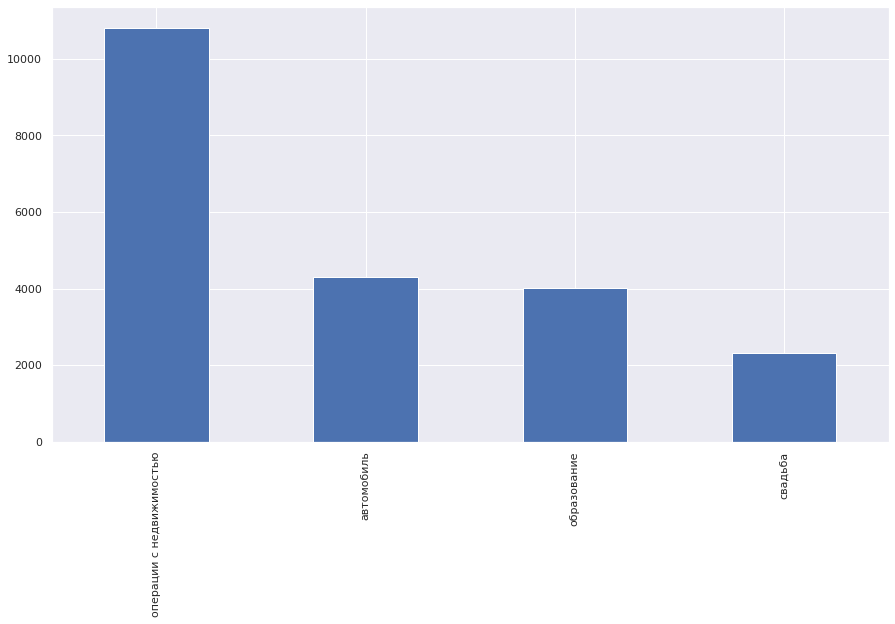

In [29]:
df['purpose_category'].value_counts().plot.bar();

Как видим, чаще всего кредиты предоставлялись для операций с недвижимостью.

**Вывод**

Лемматизация данных о целях, на которые были предоставлены кредиты, и помлдующий анализ полученных лемм и частоты их встречи позволили определить категории целей кредитов. В данном случае категоризация целей кредитов была необходима, поскольку для одних и тех же смысловых значений в столбце *purpose* использовались разные формулировки. Категоризированные данные о целях кредитов упростят работы по проверке основной гипотезы исследования.

### Категоризация данных

Осуществим категоризацию данных, содержащихся в датасете, что упростит последующий анализ и проверку предположений. Выполним категоризацию следующих данных: о наличии и количестве детей, возрасту заёмщиков, ежемесячному доходу заёмщиков и их семейному статусу.

#### Категоризация данных о наличии и количестве детей

Для начала определим какие уникальные значения содержаться в столбце *children* датафрейма:

In [30]:
df['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

Таким образом, у заёмщиков имеется от 0 до 5 детей. Также встречаются и анамальные значения: - 1 и 20. Обработаем их до перехода к категоризации.

Приведём отрицательные значения к положительным с помощью функции `abs`, предположив, что отрицательные значения появились в результате ошибки и на самом деле имеются в виду наличие одного ребёнка:

In [31]:
df['children'] = df['children'].apply(abs)
df['children'].unique()

array([ 1,  0,  3,  2,  4, 20,  5])

В результате, значений *-1* в столбце children не осталось.

Теперь обработаем значения *20*. Для начала посчитаем сколько раз это значение встречается. Возможно, если это единичный случай, то значения и не являются аномальными:

In [32]:
df['children'].value_counts()

0     14091
1      4855
2      2052
3       330
20       76
4        41
5         9
Name: children, dtype: int64

Поскольку данные о 20 детях содержаться в отношении 76 заёмщиков, что маловероятно, предположим, что такое значение появилось в результате ошибок при внесении данных: на самом деле должно было быть указано значение *2*, а *0* появился ошибочно.
Заменим данные в ячейках столбаца *children* со значением *20* на значение *2* с помощью функции `where()` библиотеки numpy:

In [33]:
df['children'] = np.where(df['children'] == 20, 2, df['children'])
df['children'].unique()

array([1, 0, 3, 2, 4, 5])

Таким образом, данных со значением *20* в столбце *children* не осталось.

Выполним категоризацию данных о наличии и количестве детей, для чего напишем функцию, которая для заёмщиков без детей будет возвращать *0*, а для заёмщиков с детьми - *1*:

In [34]:
def having_children(i): # Аргументом функции будет выступать конкретное значение о наличии детей.
    if i == 0:          # Если значение будет равно 0,
        return 0        # то функция будет возвращать 0 - категория заёмщиков без детей.
    elif i >= 1:        # Но если значение будет от 1 и больше,
        return 1        # то функция вернёт 1 - категория заёмщиков с детьми.

Создадаим столбец *children_id*, в котором будут хранится данные о категориях заёмщиков применительно к наличию у них детей, где *0* - дети отсутствуют, *1* - дети имеются:

In [35]:
df['children_id'] = df['children'].apply(having_children) # Для создание столбца применим функцию 
                                                          # having_children к столбцу children.

Теперь создадим переменную *children_status_dict*, в которой сохраним данные столбцов *children_id* и *children* и удалим дубликаты.

In [36]:
children_status_dict = df[['children_id', 'children']]
children_status_dict = children_status_dict.drop_duplicates().reset_index(drop=True)
children_status_dict

,children_id,children
0,1,1
1,0,0
2,1,3
3,1,2
4,1,4
5,1,5


Как видим, функция having_children сработала корректно.

**Вывод**

Теперь в датафрейме имеется столбец *children_id*, содержащий категории для заёмщиков без детей (*0*) и с детьми (*1*). "Словарём" для данной категоризации выступает переменная *having_children_dict*.

#### Категоризация данных о возрасте

Выполним категоризацию данных о возрасте заёмщиков. Cохраним в переменной *age_groups* наименования для категорий возрастных групп: молодой возраст, средний возраст, пожилой возраст, старческий возраст.
Затем создадим новый столбец *age_id*, в котором будет указана возрастная группа заёмщика. Для определения к какой возрастной группе относится каждый заёмщик воспользуемся функцией `pd.qcut` с параметром `q=4`, которая разобьёт данные о возрасте заёмщика на квартили, т.е. на 4 части, содержащие примерно одинаковое количество значений. Также укажем параметр `labels`, которому придадим значения из переменной *age_groups*:

In [37]:
# Сохраняем в переменной age_groups наименования для возрастных категорий:
age_groups = ['молодой возраст', 'средний возраст', 'пожилой возраст', 'старческий возраст']

# Создадти новый столбец в датафреёме *age_id*, в котором будет указана возрастная группа заёмщика.
# С помощью параметра labels=age_groups определим наименования для каждого квартиля: первому квартили будет 
# соответствовать категория "молодой возраст", второму квартилю - "средний возраст", третьему квартилю - "пожилой возраст",
# четвертому квартилю - "старческий возраст".
df['age_id'] = pd.qcut(df['age'], 
                                q=4,                      
                               labels = age_groups)

# Посчитаем сколько раз встречается каждая возрастная категория
df['age_id'].value_counts()

молодой возраст       5467
пожилой возраст       5448
средний возраст       5284
старческий возраст    5255
Name: age_id, dtype: int64

Как видим, распределение заёмщиков по возрастным категориям примерно одинаковое.

Определим в качестве "словаря" категоризации по возрасту переменную *age_id_dict*, выведем его на экран:

In [38]:
age_id_dict = df[['age_id', 'age']]
age_id_dict = age_id_dict.drop_duplicates().reset_index(drop=True)
age_id_dict.head(10)

,age_id,age
0,средний возраст,42
1,средний возраст,36
2,молодой возраст,33
3,молодой возраст,32
4,пожилой возраст,53
5,молодой возраст,27
6,пожилой возраст,43
7,пожилой возраст,50
8,средний возраст,35
9,средний возраст,41


В результате функция определила к какой из четырёх возрастных категорий относится заёмщиков исходя их данных о его возрасте.

Построим диаграмму, чтобы увидеть (*еще раз*) распределение заёмщиков по возрастным категориям:

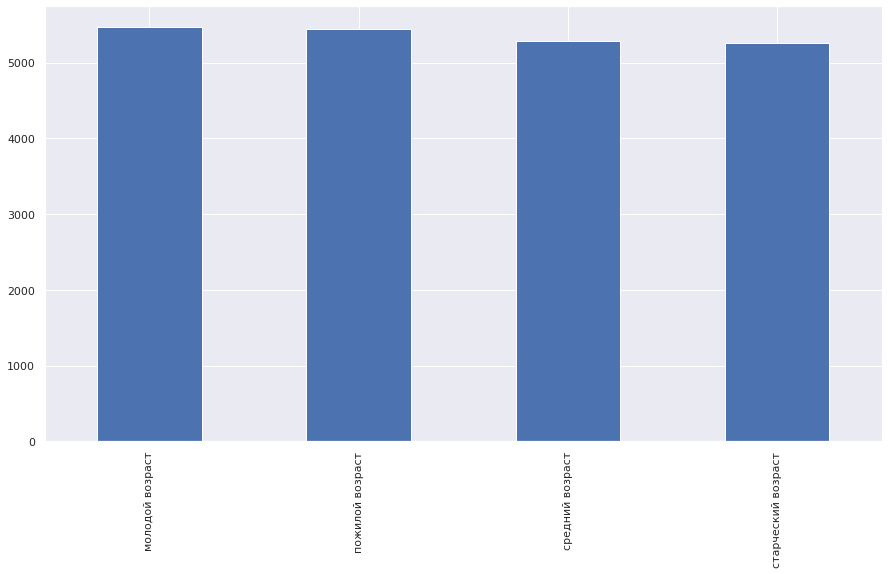

In [40]:
df['age_id'].value_counts().plot.bar();

**Вывод**

Добавили в датафреём столбец *age_id*, в котором сохранили категории возрастных групп заёмщиков (молодые, средний, пожилой, старческий).

#### Категоризация данных о ежемесячном доходе

Выполним категоризацию данных о ежемесячном доходе заёмщиков. Cохраним в переменной *income_category* наименования для категорий ежемесячного дохода: низкий доход, средний доход, высокий доход и очень высокий доход.
Затем создадим новый столбец *total_income_id*, в котором будет указана категория ежемесячного дохода. Для определения к какой категории относится доход каждого из заёмщтка воспользуемся функцией `pd.qcut` с параметром `q=4`, которая разобьёт данные о ежемесячном возрасте на квартили, т.е. на 4 части, содержащие примерно одинаковое количество значений. Также укажем параметр `labels`, которому придадим значения из переменной *income_category*:

In [41]:
# Сохраняем в переменной income_category наименования для категорий доходов заёмщиков:
income_category = ['низкий доход', 'средний доход', 'высокий доход', 'очень высокий доход']

# Создадти новый столбец в датафреёме *total_income_id*, в котором будет указана категория дохода заёмщика.
# С помощью параметра labels=income_category определим наименования для каждого квартиля: первому квартили будет 
# соответствовать категория "низкий доход", второму квартилю - "средний доход", третьему квартилю - "высокий доход",
# четвертому квартилю - "очень высокий доход".
df['total_income_id'] = pd.qcut(df['total_income'], 
                                q=4,                      
                               labels = income_category)

# Посчитаем сколько раз встречается каждая возрастная категория
df['total_income_id'].value_counts()

средний доход          5629
очень высокий доход    5364
низкий доход           5364
высокий доход          5097
Name: total_income_id, dtype: int64

C помощью функции `pd.qcut()` разбили заёмщиков на четыре примерно равные категории по уровню их дохода.

Определим в качестве "словаря" категоризации по ежемесячному доходу переменную *total_income_dict*, выведем 10 первых его значений на экран:

In [42]:
total_income_dict = df[['total_income', 'total_income_id']]
total_income_dict = total_income_dict.drop_duplicates().reset_index(drop=True)
total_income_dict.head(10)

,total_income,total_income_id
0,"253,875.64",очень высокий доход
1,"112,080.01",средний доход
2,"145,885.95",высокий доход
3,"267,628.55",очень высокий доход
4,"158,616.08",высокий доход
5,"255,763.57",очень высокий доход
6,"240,525.97",очень высокий доход
7,"135,823.93",средний доход
8,"95,856.83",низкий доход
9,"144,425.94",высокий доход


Функция сработала корректно, что позволило определить к какой из категорий относится заёмщик.

**Вывод**

Добавили в датафреём столбец *total_income_id*, в котором сохранили категории заёмщиков исходя из ежемесячного дохода (низкий доход, средний доход, высокий доход и очень высокий доход).

#### Категоризация данных о семейном статусе

Определять категории семейного статуса нам не потрубется, т.к. в датафрейме уже имеется столбец *family_status_id*, содержащие индексы для каждого семейного статуса в столбце *family_status*. 
Поэтому создадим словарь, чтобы понять какому значению *family status* соответствует *family_status_id*: 

In [43]:
family_status_dict = df[['family_status', 'family_status_id']]
family_status_dict = family_status_dict.drop_duplicates().reset_index(drop=True)
family_status_dict

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


**Вывод**

Провери категоризацию данных по наличию детей, возрасту заёмщиков, ежемесячному доходу заёмщиков и их семейному статусу. При этом для данных о налчии детей определили для заёмщиков без детей значение, а для заёмщиков с детьми - *1*. Выделили категории возрастных групп заёмщиков (*молодой, средний, пожилой, старческий*). Также категоризировали данные о ежемесячном доходе заёмщиков.
Для данных о семейном статусе создали "словарь" значений и соответствующего id.
Проделенная работа по категоризации данных упростит работу над основными вопросами исследования.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Для определения взаимосвязи разобьём заёмщиков на четыре категории:
* заёмщики с детьми и просрочкой возврата кредита - **1**;
* заёмщики с детьми без просрочки возврата кредита - **2**;
* заёмщики без детей с просрочкой возврата кредита - **3**;
* заёмщики без детей и без просрочки возврата кредита - **4**.

Напишем функцию *children_debt*, которая будет определять к какой из указанны четырёх категорий относится заёмщик:

In [44]:
# Аругментом функции будет строка датасета, значения которой будут влиять на то к какой категории будет отнесён
# заёмщик. В качестве переменных children_id и debt будут выступать значения из одноимённых столбцов.
# При этом в столбце children_id 0 - заёмщики без детей, 1 - с детьми, а в столбце debt 0 - просрочка по кредиту
# отсутствовала, 1 - просрока по кредиту была.
# В теле функции с помощью условных конструкций определим какую категорию заёмщика будет возвращать функция. 

def children_debt(row):
    children_id = row['children_id']
    debt = row['debt']
    if (children_id == 1) & (debt == 1):
        return 1
    elif (children_id == 1) & (debt == 0):
        return 2
    elif (children_id == 0) & (debt == 1):
        return 3
    elif (children_id == 0) & (debt == 0):
        return 4

Создадим столбец *childs_debt_ratio* с категориями по отношению между наличием у заёмщика детей и просрочек по кредиту:

In [45]:
df['childs_debt_ratio'] = df.apply(children_debt, axis=1)
df[['debt', 'children_id', 'childs_debt_ratio']].head(10)

,debt,children_id,childs_debt_ratio
0,0,1,2
1,0,1,2
2,0,0,4
3,0,1,2
4,0,0,4
5,0,0,4
6,0,0,4
7,0,0,4
8,0,1,2
9,0,0,4


Можем убедиться на примере первых 10 значений в корректности работы функции *children_debt*.

Рассчитем какой процент у каждой категории заёмщиков по  отношению наличия детей и просрочки по кредиту:

In [46]:
df['childs_debt_ratio'].value_counts(normalize=True) * 100 

4   60.73
2   31.16
3    4.95
1    3.16
Name: childs_debt_ratio, dtype: float64

Следовательно, в датафрейме больше всего данных о заёмщиках **4** категории - не имеющих детей и просрочек по кредиту. Заёмщиков, допустивших просрочки по кредиту, всего около 8% от всех займщиков.

Создадим цикл со счётчиком, который посчитает количество заёмщиков в каждой категории по отношению наличия детей и просрочки:

In [47]:
with_childs_with_debt = 0 # Количество заёмщиков имеющих детей и просрочку по кредиту.
with_childs_no_debt = 0   # Количество заёмщиков имеющих детей и не имеющих просрочку по кредиту.
no_childs_with_debt = 0   # Количество заёмщиков без детей и с просрочкой по кредиту.
no_childs_no_debt = 0     # Количество заёмщиков без детей и без просрочки по кредиту.

# Цикл пройдётся по всем значениям столбца childs_debt_ratio, посчитает количество заёмщиков каждой категории и
# сохранит данные в соответствующую переменную.
for i in df['childs_debt_ratio']: 
    if i == 1:
        with_childs_with_debt += 1
    elif i == 2:
        with_childs_no_debt += 1
    elif i == 3:
        no_childs_with_debt += 1
    elif i == 4:
        no_childs_no_debt += 1
        
# Выведем результат на эксран 
print(f'Количество заёмщиков имеющих детей и просрочку по кредиту: {with_childs_with_debt}')
print(f'Количество заёмщиков имеющих детей и не имеющих просрочку по кредиту: {with_childs_no_debt}')
print(f'Количество заёмщиков без детей и с просрочкой по кредиту: {no_childs_with_debt}')
print(f'Количество заёмщиков без детей и без просрочки по кредиту: {no_childs_no_debt}')

Количество заёмщиков имеющих детей и просрочку по кредиту: 678
Количество заёмщиков имеющих детей и не имеющих просрочку по кредиту: 6685
Количество заёмщиков без детей и с просрочкой по кредиту: 1063
Количество заёмщиков без детей и без просрочки по кредиту: 13028


Создадим датафрейм *report_1*, где в качестве столбцов укажем категории заёмщиков по отношению наличия детей и просрочки по кредиту, а значениями будут количество заёмщиков для каждой категории:

In [48]:
report_1 = pd.DataFrame({
    'with_childs_with_debt' : [with_childs_with_debt],
    'with_childs_no_debt' : [with_childs_no_debt],
    'no_childs_with_debt' : [no_childs_with_debt],
    'no_childs_no_debt' : [no_childs_no_debt]},
index = [1])
report_1

,with_childs_with_debt,with_childs_no_debt,no_childs_with_debt,no_childs_no_debt
1,678,6685,1063,13028


Рассчитаем какой процент заёмщиков с детьми имеют просрочку по кредиту, результат сохраним в столбце *percent_of_debt_with_childs*, а также процент заёмщиков без детей с просрочкой в столбце *percent_of_debt_no_childs*:

In [49]:
# Для рассчёта процента заёмщиков с детьми и просрочкой по кредиту поделим количество заёмщиков с детьми и просрочкой
# на общее количество заёмщиков с детьми.

report_1['percent_of_debt_with_childs'] = report_1['with_childs_with_debt'] / (
    report_1['with_childs_with_debt'] + report_1['with_childs_no_debt'])

# Для рассчёта процента заёмщиков без детей, но с просрочкой по кредиту поделим количество заёмщиков без детьей
# и c просрочкой на общее количество заёмщиков без детей.

report_1['percent_of_debt_no_childs'] = report_1['no_childs_with_debt'] / (
    report_1['no_childs_with_debt'] + report_1['no_childs_no_debt'])

report_1.style.format(
    {('percent_of_debt_with_childs'): '{:.2%}', ('percent_of_debt_no_childs'):'{:.2%}'})

,with_childs_with_debt,with_childs_no_debt,no_childs_with_debt,no_childs_no_debt,percent_of_debt_with_childs,percent_of_debt_no_childs
1,678,6685,1063,13028,9.21%,7.54%


В результате мы получили данные, что 9,21% заёмщиков с детьми имеют просрочку по кредиту, в то время как заёмщики без детей имеют просрочку только в 7,54% случаев.

**Вывод**

В результате проведённого исследования было устанолвлено, что заёмщики с детьми чаще допускают просрочки по кредиту, чем заёмщики без детей.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

Оценим как меняется процент невозврата кредита в срок в зависимости от семейного статуса, используем код, аналогичный предыдущему:

In [50]:
# Посчитаем количество заёмщиков по каждому значению в столбце family_status имеющих долг, а также среднее
# значение таких заёмщиков в каждой категории семейного статуса. Для этого проведем группировку по столбцу 
# family_status, а затем с помощью метода agg() укажем какие операции надо провести по столбцу debt:
report_2 = df.groupby('family_status').agg({'debt': ['mean', 'count']})

# Переименуемый мультииндексы в колонках:
report_2 = report_2.rename(columns = {'debt': 'Верхний уровень'}, level=0)
report_2 = report_2.rename(columns = {'mean': '% невозврата', 'count': 'Количество заёмщиков'}, level=1)

# Переменуемый индекс:
report_2.index = report_2.index.rename('Семейный статус')

# Выедем результат на экран:
report_2.style.format(
    {('Верхний уровень', '% невозврата'): '{:.2%}', ('Верхний уровень', 'Количество заёмщиков'):'{:.2f}'})

**Вывод**

Семейный статус заёмщика и просрочки по кредиту связаны следующим образом:
* заёмщиков, не состоящих в браке (не считая заёмщиков в разводе и вдов/вдовцов), и заёмщиков, состоящих в гражданском браке, допускающих просрочку по кредиту примерно одинаковый процент;
* заёмщики в браке и в разводе допускают просрочку по кредиту сопостовимое процентное значение;
* меньше всего вероятность просрочки у заёмщиц-вдов и заёмщиков-вдовцов.

Следовательно, взаимосвязь между семейным статусом и вероятность просрочки по кредиту подтверждена.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Аналогичным образом определим зависимость между уровнем дохода и вероятностью просрочки кредита. Используем категории уровня дохода, которые мы определили в столбце *total_income_id*:

In [51]:
# Посчитаем количество заёмщиков по каждой категории в столбце total_income_id имеющих долг, а также среднее
# значение таких заёмщиков в каждой категории. Для этого проведем группировку по столбцу total_income_id,
# а затем с помощью метода agg() укажем какие операции надо провести по столбцу debt:
report_3 = df.groupby('total_income_id').agg({'debt': ['mean', 'count']})

# Переименуемый мультииндексы в колонках:
report_3 = report_3.rename(columns = {'debt': 'Верхний уровень'}, level=0)
report_3 = report_3.rename(columns = {'mean': '% невозврата', 'count': 'Количество заёмщиков'}, level=1)

# Переменуемый индекс:
report_3.index = report_3.index.rename('Уровень дохода')

# Выедем результат на экран:
report_3.style.format(
    {('Верхний уровень', '% невозврата'): '{:.2%}', ('Верхний уровень', 'Количество заёмщиков'):'{:.2f}'})

**Вывод**

Уровнь дохода влияет на вероятность просрочки по кредиту следующим образом:
* заёмщики с низким доходом и с очень высоким доходом допускают просрочки по кредитам меньшее количество раз, чем заёмщики с высоким и средним доходом.

Поэтому возможно утверждать о наличии взаимосвязи между уровнем дохода и совевременным возвратом кредита.

- Как разные цели кредита влияют на его возврат в срок?

Установим есть ли зависимость между целями, на которые были предоставлены кредиты, и вероятностью просрочки по ним. Используем категории целей кредитов, которые мы определили в столбце *purpose_category*:

In [52]:
# Посчитаем количество заёмщиков по каждой категории в столбце purpose_category имеющих долг, а также среднее
# значение таких заёмщиков в каждой категории. Для этого проведем группировку по столбцу purpose_category,
# а затем с помощью метода agg() укажем какие операции надо провести по столбцу debt:
report_4 = df.groupby('purpose_category').agg({'debt': ['mean', 'count']})

# Переименуемый мультииндексы в колонках:
report_4 = report_4.rename(columns = {'debt': 'Верхний уровень'}, level=0)
report_4 = report_4.rename(columns = {'mean': '% невозврата', 'count': 'Количество заёмщиков'}, level=1)

# Переменуемый индекс:
report_4.index = report_4.index.rename('Категория цели кредита')

# Выедем результат на экран:
report_4.style.format(
    {('Верхний уровень', '% невозврата'): '{:.2%}', ('Верхний уровень', 'Количество заёмщиков'):'{:.2f}'})

**Вывод**

Взаимосвязи между категориями целей кредитов и невозвартом кредитов в срок проявляются в следующем:
* кредиты, предоставленные по категориям целей "автомобиль" и "образование", чаще всего не возвращаются в срок примерно с одинаковой вероятностью;
* меньше всего просрочек у клиентов, которым кредиты были предоставлены по категории цели "операции с недвижимостью".

Соответственно, связь между целью кредита и его возвратом в срок также выявлена.

## Шаг 4. Общий вывод

По результатам исследования была установлена взаимосвязь между возвратом кредита в срок и:
* наличием и количеством детей у заёмщика:
    * чаще всего просрочки допускают заёмщики с детьми
* семейным статусом заёмщика:
    * самые дисциплинированные заёмщицы-вдовы и заёмщики-вдовцы, в то время как заёмщики, не состоящие в браке или состоящие в гражданском браке, чаще других не исполняют обязательства по возврату кредитов в срок
* уровнем дохода заёмщика:
    * заёмщики со средним и высоким доходами чаще не возвращают кредиты в срок, чем заёмщики с низким и очень высоким доходами
* целей кредита:
    * вероятность невозврата кредита в срок выше по кредитам для целей, связанных с автомобилями и образованием, чем по кредитам на операции с недвижимостью и свадьбы.
    
Следовательно, гипотеза о наличии взаимосвязи между отдельными характеристиками заёмщиков и вероятностью просрочки по кредиту подтверждена, цель исследования достигнута.